# Harmful Hate and Offensive Speech Detection

***DISCLAIMER:*** This project contains **offensive** and **harmful** words/slurs.

### 1. Required Packages

In [16]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

%pip install emoji

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chanbormey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/chanbormey/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chanbormey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chanbormey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chanbormey/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chanbormey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Note: you may need to restart the kernel to use updated packages.


### 2. Data Loading

In [18]:
file_path = 'archive/data/labeled_data.csv'

try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully.")
    print(f"Dataset contains {df.shape[0]} samples.")
except FileNotFoundError:
    print(f"File not found: {file_path}")

label_map = {
    0: 'Hate Speech', 
    1: 'Offensive Language', 
    2: 'Neither'
}
    
df['label_name'] = df['class'].map(label_map)

print("\nThe First 5 Rows of the Dataset:")
print(df[['class', 'label_name', 'tweet']].head())

print("\nClass Distribution:")
print(df['label_name'].value_counts())

Data loaded successfully.
Dataset contains 24783 samples.

The First 5 Rows of the Dataset:
   class          label_name  \
0      2             Neither   
1      1  Offensive Language   
2      1  Offensive Language   
3      1  Offensive Language   
4      1  Offensive Language   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  

Class Distribution:
label_name
Offensive Language    19190
Neither                4163
Hate Speech            1430
Name: count, dtype: int64


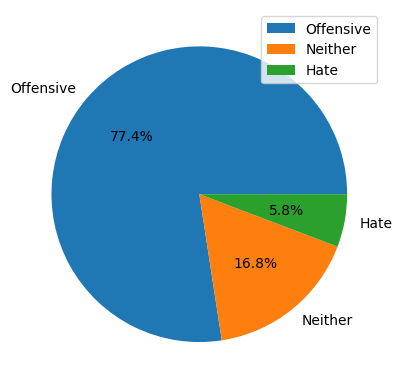

In [19]:
# Data Visualization
counts = df['class'].value_counts()
labels = [{0: 'Hate', 1: 'Offensive', 2: 'Neither'}[x] for x in counts.index]

plt.pie(counts.values,
        labels=labels,
        autopct='%1.1f%%')
plt.legend(labels)
plt.show()

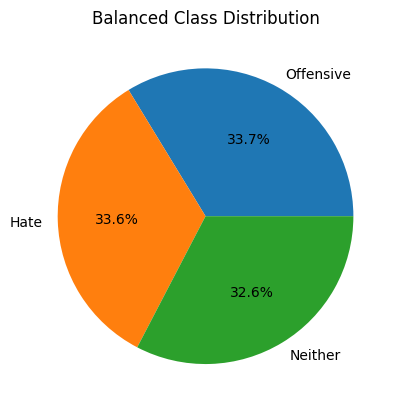

In [ ]:
# Balancing the dataset
class_0 = df[df['class'] == 0]                                    # Hate Speech, upsampled
class_1 = df[df['class'] == 1].sample(n=4300, random_state=42)    # Offensive Language, downsampled
class_2 = df[df['class'] == 2]                                    # Neither

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

# Visualize the balanced distribution
counts = balanced_df['class'].value_counts()
labels = [{0: 'Hate', 1: 'Offensive', 2: 'Neither'}[x] for x in counts.index]

plt.pie(counts.values,
        labels=labels,
        autopct='%1.1f%%')
plt.title("Balanced Class Distribution")
plt.show()

In [21]:
# Display balanced class distribution
print("\nClass Distribution:")
print(balanced_df['label_name'].value_counts())


Class Distribution:
label_name
Offensive Language    4300
Hate Speech           4290
Neither               4163
Name: count, dtype: int64


In [22]:
from sklearn.model_selection import train_test_split

# Train-test split
X = balanced_df['tweet']
y = balanced_df['class']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train_text.shape[0]} samples")
print(f"Testing set size: {X_test_text.shape[0]} samples")


Training set size: 10202 samples
Testing set size: 2551 samples


### 3. Data Pre-Processing

In [ ]:
import re
import html
from nltk import pos_tag
from emoji import demojize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    text = text.lower()                                  # Lowercasing
    text = re.sub(r'\brt\b', '', text)                   # Remove RT (retweets)
    text = html.unescape(text)                           # Decode HTML entities
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)    # Remove URLs
    text = re.sub(r'@\w+|\#', '', text)                  # Remove Twitter handles and hashtags
    text = re.sub(r'[^a-zA-Z\s!?.]', '', text)           # Remove special characters but keep apostrophes 
    text = re.sub(r'\s+', ' ', text).strip()             # Remove extra whitespace
    text = demojize(text)                                # Convert emojis to text
    
    tokens = word_tokenize(text) 
    
    pos_tags = pos_tag(tokens)
    
    # Set stopwords excluding negations
    stop_words = set(stopwords.words('english'))
    negations = {"no", "not", "nor", "n't", "ain", "aren", "couldn", "didn", "doesn", "hadn", "hasn", "haven", "isn", "mightn", "mustn", "needn", "shan", "shouldn", "wasn", "weren", "won", "wouldn"}
    stop_words = stop_words - negations
    
    processed_tokens = []
    lemmatizer = WordNetLemmatizer()
    
    # Iterate through tokens and POS tags
    for token, tag in pos_tags:
        if token not in stop_words and len(token) > 2:
            lemmatizer_token = lemmatizer.lemmatize(token)
            
            processed_tokens.append(lemmatizer_token)
            
            sent_pos = set(['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'])
            if tag in sent_pos:
                processed_tokens.append(f"{lemmatizer_token}_{tag}")
    
    return ' '.join(processed_tokens)

print("\nPreprocessing training data...")
X_train_processed = [preprocess_text(text) for text in X_train_text]
print("Train data preprocessing completed!\n")

print("Preprocessing testing data...")
X_test_processed = [preprocess_text(text) for text in X_test_text]
print("Test data preprocessing completed!")


Preprocessing training data...
Train data preprocessing completed!

Preprocessing testing data...
Test data preprocessing completed!


### 4. Feature Extraction: TF-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=5,
    max_df=0.8,
    sublinear_tf=True
)

X_train = vectorizer.fit_transform(X_train_processed)
X_test = vectorizer.transform(X_test_processed)

print(f"Training Matrix Shape: {X_train.shape}")
print(f"Testing Matrix Shape:  {X_test.shape}")

Training Matrix Shape: (10202, 4458)
Testing Matrix Shape:  (2551, 4458)


### 5. Model Training: Logistic Regression Model (LR)

In [25]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    C=1.0,
    class_weight='balanced'
)

print("Training Logistic Regression...")
lr_classifier.fit(X_train, y_train)

print("Training Completed!")
print("Number of classes:", len(lr_classifier.classes_))
print("Classes:", lr_classifier.classes_)

Training Logistic Regression...
Training Completed!
Number of classes: 3
Classes: [0 1 2]


In [26]:
# Show most important features
feature_names = vectorizer.get_feature_names_out()

# Iterate through each class to print top features
for i, class_label in enumerate(lr_classifier.classes_):
    class_coefficients = lr_classifier.coef_[i]
    
    # Get indices of the top 10 features with the highest coefficients
    top_indices = class_coefficients.argsort()[-10:][::-1]
    
    print(f"\nTop 10 features for {label_map.get(class_label, f'Class {class_label}')}:")
    print("=" * 40)
    
    for index in top_indices:
        print(f"{feature_names[index]}: {class_coefficients[index]:.4f}")


Top 10 features for Hate Speech:
faggot: 6.3937
nigger: 5.3935
nigga: 4.7702
fag: 3.9750
dyke: 3.2863
queer: 3.0350
fuck: 2.9453
as: 2.6672
coon: 2.5424
wetback: 2.4952

Top 10 features for Offensive Language:
bitch: 11.0956
hoe: 5.9972
pussy: 5.8540
shit: 2.7236
aint: 1.7527
female: 1.6405
cunt: 1.5955
niggah: 1.5363
as: 1.5215
fuck: 1.4144

Top 10 features for Neither:
bird: 4.5957
yankee: 4.0331
charlie: 3.7876
mock: 2.8784
brownie: 2.8026
trash: 2.7029
yellow: 2.5168
oreo: 2.3132
jihadi: 2.1105
colored: 1.8125


In [27]:
import joblib

#Save the fitted vectorizer and trained classifier
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(lr_classifier, "hate_speech_model.pkl")

print("Artifacts saved!")

Artifacts saved!


### 6. Model Evaluation

Test Set Accuracy: 0.860 (86.0%)

Detailed Classification Report:
                    precision    recall  f1-score   support

       Hate Speech       0.85      0.82      0.84       858
Offensive Language       0.84      0.82      0.83       860
           Neither       0.88      0.94      0.91       833

          accuracy                           0.86      2551
         macro avg       0.86      0.86      0.86      2551
      weighted avg       0.86      0.86      0.86      2551


Confusion Matrix:
[[706 109  43]
 [ 94 707  59]
 [ 27  24 782]]


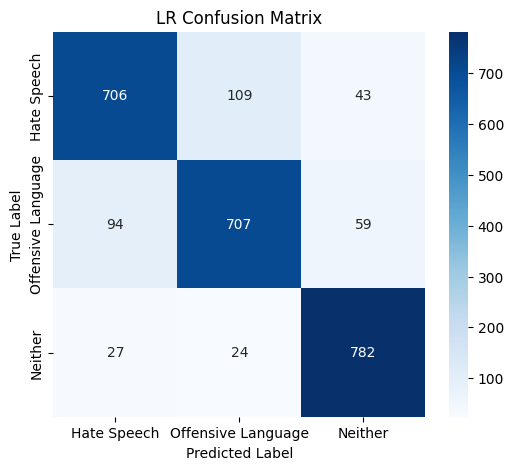

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Test set evaluation for LR
y_pred = lr_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Set Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")

# Detailed classification report
print("\nDetailed Classification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred, 
                          target_names=['Hate Speech', 'Offensive Language', 'Neither']))

# Confusion Matrix Plot for LR
cm_lr = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm_lr)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate Speech', 'Offensive Language', 'Neither'],
            yticklabels=['Hate Speech', 'Offensive Language', 'Neither'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LR Confusion Matrix')
plt.show()

### 7. Making Prediction

In [ ]:
import numpy as np

def get_lr_confidence(model, vector):
    """
    Return the probability distribution over classes for a single sample.
    Uses predict_proba if available; otherwise falls back to softmax(decision_function).
    The function handles single-row vectors by reshaping where necessary.
    """
    # Ensure the vector is 2D when passed to sklearn methods
    try:
        probs = model.predict_proba(vector)[0]
        return probs
    except Exception:
        # Fallback: try reshaping then predict_proba (works for numpy / sparse)
        try:
            probs = model.predict_proba(vector.reshape(1, -1))[0]
            return probs
        except Exception:
            # Last resort: use decision_function (then apply softmax)
            raw_scores = model.decision_function(vector)
            if raw_scores.ndim == 1:
                raw_scores = raw_scores
            else:
                raw_scores = raw_scores[0]
            exp_scores = np.exp(raw_scores - np.max(raw_scores))
            return exp_scores / exp_scores.sum()

sample_size = 5
sample_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)

correct_count = 0

print(f"PREDICTIONS ON RANDOM TEST SET SAMPLES (Using Logistic Regression)")
print('=' * 60)

for i, idx in enumerate(sample_indices):
    original_text = X_test_text.iloc[idx]
    actual_label = y_test.iloc[idx]
    
    feature_vector = X_test[idx]  

    # Prediction (label)
    prediction = lr_classifier.predict(feature_vector)[0]

    # Probabilities and confidence
    probs = get_lr_confidence(lr_classifier, feature_vector)
    confidence = probs.max()

    print(f"\nSample {i+1}:")
    print(f"Original Text: \"{original_text}\"")
    print(f"Actual Label:    {actual_label} ({label_map.get(actual_label)})")
    print(f"Predicted Label: {prediction} ({label_map.get(prediction)})")
    print(f"Confidence Score: {confidence:.2f}")

    if prediction == actual_label:
        print("Result: ✔︎ Correct\n")
        correct_count += 1
    else:
        print("Result: ✘ Incorrect\n")
        
    print('-' * 60)

print(f"\nTotal Correct: {correct_count} out of {sample_size}")


PREDICTIONS ON RANDOM TEST SET SAMPLES (Using Logistic Regression)

Sample 1:
Original Text: "RT @djvlad: "if your sis is a bitch, brother is a jerk,
leave 'em both alone and continue with your work" - Q-Tip"
Actual Label:    1 (Offensive Language)
Predicted Label: 0 (Hate Speech)
Confidence Score: 0.46
Result: ✘ Incorrect

------------------------------------------------------------

Sample 2:
Original Text: "RT @A1lovely_: At least i say im crazy...some nigga gotta find out a bitch wild when she shooting at they ass &#128514;"
Actual Label:    0 (Hate Speech)
Predicted Label: 0 (Hate Speech)
Confidence Score: 0.62
Result: ✔︎ Correct

------------------------------------------------------------

Sample 3:
Original Text: "@BeavisCumia @jimmysdong
Dat cat gonna scratch all up on dat colored boy and he gonna end up in da chow mein"
Actual Label:    2 (Neither)
Predicted Label: 2 (Neither)
Confidence Score: 0.66
Result: ✔︎ Correct

---------------------------------------------------------

In [30]:
custom_samples = [
    "All blacks are dangerous criminals and should be expelled.",
    "I can stand the Niggas, they are like vermin.",
    "You represent everything wrong with this game. You are a fucking idiot.",
    "This code is absolute garbage, whoever wrote this sucks.",
    "I disagree with your interpretation of the data.",
    "The history of that region is complex and involves many conflicts.",
]

print("PREDICTIONS USING LR")
print('=' * 60)

for i, sample in enumerate(custom_samples):
    processed_sample = preprocess_text(sample)
    review_vector = vectorizer.transform([processed_sample])
    
    prediction = lr_classifier.predict(review_vector)[0]
    
    # Calculate Confidence
    probabilities = get_lr_confidence(lr_classifier, review_vector)
    confidence = probabilities.max()
    
    print(f"\nSample {i+1}: {sample}")
    print(f"Predicted Label: {label_map.get(prediction)}")
    print(f"Confidence Score: {confidence:.2f}")
    print("Class Scores:")
    for class_idx, score in enumerate(probabilities):
        print(f"  {label_map.get(class_idx)}: {score:.3f}")
    print()
    print('-' * 60)

PREDICTIONS USING LR

Sample 1: All blacks are dangerous criminals and should be expelled.
Predicted Label: Hate Speech
Confidence Score: 0.59
Class Scores:
  Hate Speech: 0.592
  Offensive Language: 0.104
  Neither: 0.303

------------------------------------------------------------

Sample 2: I can stand the Niggas, they are like vermin.
Predicted Label: Hate Speech
Confidence Score: 0.87
Class Scores:
  Hate Speech: 0.869
  Offensive Language: 0.088
  Neither: 0.043

------------------------------------------------------------

Sample 3: You represent everything wrong with this game. You are a fucking idiot.
Predicted Label: Hate Speech
Confidence Score: 0.42
Class Scores:
  Hate Speech: 0.420
  Offensive Language: 0.389
  Neither: 0.191

------------------------------------------------------------

Sample 4: This code is absolute garbage, whoever wrote this sucks.
Predicted Label: Hate Speech
Confidence Score: 0.45
Class Scores:
  Hate Speech: 0.446
  Offensive Language: 0.182
  Ne